# Creating the graph

Within graph-based weather models one single graph is used to represent the encode-process-decode operations of the data-driven weather model. The graph is a directed acyclic graph (DAG) with the nodes representing features at a given location in space and the edges representing flow of information.

The graph is comprised of three components that represent the three encode-process-decode operations:

- `g2m`: The encoding from the physical *grid* space onto the computational *mesh* space.
- `m2m`: The processing of the data in the computational *mesh* space.
- `m2g`: The decoding from the computational *mesh* space onto the physical *grid* space.

The graph is a directed acyclic graph (DAG) with the nodes representing points in space and the edges 


*Table of contents*

- [Introduction](#Introduction)
- [The grid graph component](#The-grid-graph-component)
- [Graph archetypes](#graph-archetypes)
    - [Keissler flat nearest neighbor graph](#the-keisler-2022-single-range-mesh)
    - [Graphcast](#graphcast-lam-et-al-2022-graph)
    - [Oscarsson hierarchical graph](#



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import weather_model_graphs as wmg

In [2]:
def _create_fake_xy(N=10):
    x = np.linspace(0, 1, N)
    y = np.linspace(0, 1, N)
    xy = np.meshgrid(x, y)
    xy = np.stack(xy, axis=0)
    return xy

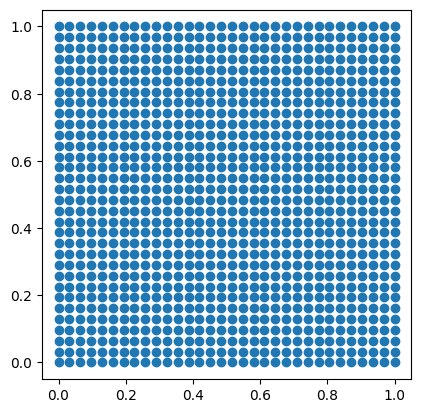

In [4]:
xy = _create_fake_xy(32)

fig, ax = plt.subplots()
ax.scatter(xy[0], xy[1])
ax.set_aspect(1)

## The "mesh" graph

Lets start with a simple mesh which only has nearest neighbour connections.

In [ ]:
g_m2m = wmg.create.mesh.create_single_level_2d_mesh_graph(xy=xy, nx=12, ny=12)

wmg.visualise.nx_draw_with_pos_and_attr(g_m2m)

# Graph archetypes

## The Keisler 2022 single-range mesh

In [ ]:
graph = wmg.create.archetype.create_keisler_graph(xy_grid=xy)
graph

In [ ]:
wmg.visualise.nx_draw_with_pos_and_attr(
    graph, node_size=30, edge_color_attr="component", node_color_attr="type"
)

In [ ]:
graph_components = wmg.create.archetype.create_keisler_graph(
    xy_grid=xy, merge_components=False
)
graph_components

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 5))

for (name, graph), ax in zip(graph_components.items(), axes.flatten()):
    pl_kwargs = {}
    if name == "m2m":
        pl_kwargs = dict(edge_color_attr="len")
    elif name == "g2m" or name == "m2g":
        pl_kwargs = dict(edge_color_attr="len", node_color_attr="type")

    wmg.visualise.nx_draw_with_pos_and_attr(graph, ax=ax, node_size=30, **pl_kwargs)
    ax.set_title(name)

## GraphCast (Lam et al 2022) graph

In [ ]:
graph = wmg.create.archetype.create_graphcast_graph(xy_grid=xy)

In [ ]:
wmg.visualise.nx_draw_with_pos_and_attr(
    graph, node_size=30, edge_color_attr="component", node_color_attr="type"
)

In [ ]:
graph_components = wmg.create.archetype.create_graphcast_graph(
    xy_grid=xy, merge_components=False, refinement_factor=3
)
graph_components

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 24))

for (name, graph), ax in zip(graph_components.items(), axes.flatten()):
    pl_kwargs = {}
    if name == "m2m":
        pl_kwargs = dict(edge_color_attr="len", node_color_attr="level", node_size=10)
    elif name == "g2m" or name == "m2g":
        pl_kwargs = dict(edge_color_attr="len", node_color_attr="type", node_size=30)

    wmg.visualise.nx_draw_with_pos_and_attr(graph, ax=ax, **pl_kwargs)
    ax.set_title(name)
    ax.set_aspect(1.0)

## Oscarsson et al 2023 hierarchical graph

In [ ]:
graph = wmg.create.archetype.create_oscarsson_hierarchical_graph(xy_grid=xy)
graph

In [ ]:
wmg.visualise.nx_draw_with_pos_and_attr(
    graph, node_size=30, edge_color_attr="component", node_color_attr="type"
)

In [ ]:
graph_components = wmg.create.archetype.create_oscarsson_hierarchical_graph(
    xy_grid=xy, merge_components=False
)
graph_components

Here we will further split the `m2m` graph component into three: 1) `m2m_up`, 2) `m2m_inlevel` and 3) `m2m_down`, using the utility function
`wmg.split_graph_by_edge_attribute(...)`, so that we can visualise these three parts separately:

In [ ]:
m2m_graph = graph_components.pop("m2m")
m2m_graph_components = wmg.split_graph_by_edge_attribute(
    graph=m2m_graph, attribute="direction"
)
m2m_graph_components = {
    f"m2m_{name}": graph for name, graph in m2m_graph_components.items()
}
graph_components.update(m2m_graph_components)

graph_components

In [ ]:
n_components = len(graph_components)
fig, axes = plt.subplots(nrows=n_components, ncols=1, figsize=(10, 9 * n_components))

for (name, graph), ax in zip(graph_components.items(), axes.flatten()):
    pl_kwargs = {}
    if name == "m2m_inlevel":
        pl_kwargs = dict(edge_color_attr="len", node_color_attr="level", node_size=10)
    elif name == "g2m" or name == "m2g":
        pl_kwargs = dict(edge_color_attr="len", node_color_attr="type", node_size=30)
    elif name in ["m2m_up", "m2m_down"]:
        pl_kwargs = dict(
            edge_color_attr="levels", node_color_attr="level", node_size=30
        )

    wmg.visualise.nx_draw_with_pos_and_attr(graph, ax=ax, **pl_kwargs)
    ax.set_title(name)
    ax.set_aspect(1.0)

In [ ]:
wmg.visualise.nx_draw_with_pos_and_attr(
    graph_components["m2m_down"],
    node_size=30,
    edge_color_attr="levels",
    node_color_attr="level",
)

# Creating your own graph architecture

Instead of creating one of the archetype above, you can also create your own
graph architecture.
This can be done by calling the `create_all_graph_components` function and
defining the `g2m`, `m2m` and `m2g` connectivity method (any arguments for
each).

In [20]:
graph_components = wmg.create.create_all_graph_components(
    m2m_connectivity="flat_multiscale",
    xy=xy,
    merge_components=False,
    m2m_connectivity_kwargs=dict(refinement_factor=3, max_num_levels=None),
    g2m_connectivity="nearest_neighbours",
    m2g_connectivity="nearest_neighbour",
    g2m_connectivity_kwargs=dict(max_num_neighbours=4),
)

2024-05-07 22:17:47.158 | DEBUG    | weather_model_graphs.create.mesh.mesh:create_multirange_2d_mesh_graphs:110 - nlev: 3, nleaf: 27, mesh_levels: 2


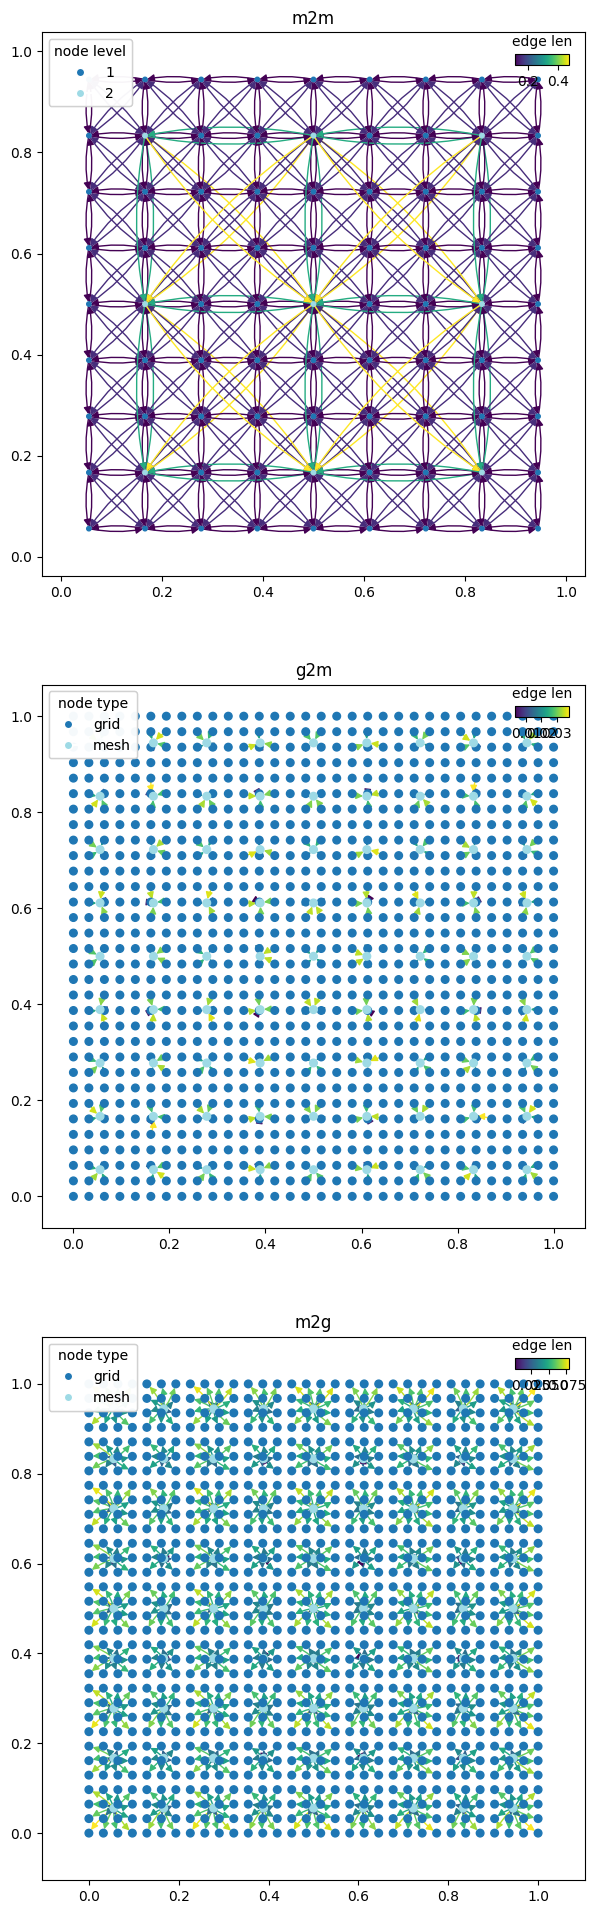

In [18]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 24))

for (name, graph), ax in zip(graph_components.items(), axes.flatten()):
    pl_kwargs = {}
    if name == "m2m":
        pl_kwargs = dict(edge_color_attr="len", node_color_attr="level", node_size=10)
    elif name == "g2m" or name == "m2g":
        pl_kwargs = dict(edge_color_attr="len", node_color_attr="type", node_size=30)

    wmg.visualise.nx_draw_with_pos_and_attr(graph, ax=ax, **pl_kwargs)
    ax.set_title(name)
    ax.set_aspect(1.0)